# Libraries and Functions

In [67]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow
from skimage import io, color
from sklearn.metrics import pairwise_distances
from matplotlib.patches import Rectangle
import re

###########################################################################

def round_to_odd(number):
    rounded_number = round(number)
    return rounded_number + 1 if rounded_number % 2 == 0 else rounded_number

def plotting_histogram_hsv(image):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Flatten the HSV image to 1D arrays for plotting
    h_values = hsv_image[:, :, 0].flatten()
    s_values = hsv_image[:, :, 1].flatten()
    v_values = hsv_image[:, :, 2].flatten()

    # Create subplots for H, S, V values
    fig, axs = plt.subplots(3, 1, figsize=(10, 10))

    # Plot H values
    axs[0].hist(h_values, bins=180, color='r')
    axs[0].set_title('Hue (H)')

    # Plot S values
    axs[1].hist(s_values, bins=256, color='g')
    axs[1].set_title('Saturation (S)')

    # Plot V values
    axs[2].hist(v_values, bins=256, color='b')
    axs[2].set_title('Value (V)')

    plt.tight_layout()
    plt.show()



def calculate_hsv_range(image):

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h_values = hsv_image[:, :, 0].flatten()
    s_values = hsv_image[:, :, 1].flatten()
    v_values = hsv_image[:, :, 2].flatten()

    h_min = min(h_values)
    s_min = min(s_values)
    v_min = min(v_values)

    h_max = max(h_values)
    s_max = max(s_values)
    v_max = max(v_values)

    print((h_min, s_min, v_min), (h_max, s_max, v_max))

    return (h_min, s_min, v_min), (h_max, s_max, v_max)


def segment_image_hsv_test(image, low_thresh, high_thresh):
    brightness_threshold = 0
    shrink_factor = 0.5
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_image, low_thresh, high_thresh)
    cv2_imshow(mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    cropped_zone = image[y:y+h, x:x+w]

    #shrinking to eliminate bottle borders
    new_w = int(w * shrink_factor)
    new_h = int(h * shrink_factor)
    new_x = x + int((w - new_w) / 2)
    new_y = y + int((h - new_h) / 2)
    x, y, w, h = new_x, new_y, new_w, new_h
    cropped_zone = image[y:y+h, x:x+w]

    return cropped_zone, mask


def calculate_euclidean_distance(lab1, lab2):
    return np.linalg.norm(lab1 - lab2)


def segment_image_hsv(image, low_thresh, high_thresh):

    shrink_factor = 0.5
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_image, low_thresh, high_thresh)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_zone = image[y:y+h, x:x+w]

    #shrinking to eliminate bottle borders and read the center portion
    new_w = int(w * shrink_factor)
    new_h = int(h * shrink_factor)
    new_x = x + int((w - new_w) / 2)
    new_y = y + int((h - new_h) / 2)
    x, y, w, h = new_x, new_y, new_w, new_h
    cropped_zone = image[y:y+h, x:x+w]

    # Apply Gaussian blur to the image to reduce noise
    kernel_dimension= round_to_odd(h*0.5)
    kernel_size= (kernel_dimension, kernel_dimension)
    cropped_zone = cv2.GaussianBlur(cropped_zone, kernel_size, sigmaX=0)

    # Display the results
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Segmented Image")
    plt.imshow(cv2.cvtColor(cropped_zone, cv2.COLOR_BGR2RGB))

    plt.show()

    return cropped_zone, mask

#Convert lab coordinates given in a range of 0-255 fro OpenCV to standard values L[0-100] & a, b [-128,127]
def lab_conversion(lab_coordinates):
    std_lab_coordinates = np.zeros(3, dtype=float)
    std_lab_coordinates[0] = (lab_coordinates[0] / 255.0) * 100.0  # Scale L channel to 0-100
    std_lab_coordinates[1] = (lab_coordinates[1] / 255.0) * 255.0 - 128.0  # Scale a channel to -128-127
    std_lab_coordinates[2] = (lab_coordinates[2] / 255.0) * 255.0 - 128.0  # Scale b channel to -128-127
    return std_lab_coordinates


def cropping_background(image,x_start, y_start, x_end, y_end):

    # Crop the segmented background
    cropped_segmented_background = image[y_start:y_end, x_start:x_end]

    # Convert the cropped background to LAB color space and calculate the average LAB values
    cropped_segmented_background_lab = cv2.cvtColor(cropped_segmented_background, cv2.COLOR_BGR2LAB)
    avg_lab_background = np.mean(cropped_segmented_background_lab.reshape(-1, 3), axis=0)

    # Display the original image, mask, and segmented result for the background
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Add a Rectangle patch to highlight the cropped region
    rect = Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    plt.subplot(1, 2, 2)
    plt.title("Cropped Segmented Background")
    plt.imshow(cv2.cvtColor(cropped_segmented_background, cv2.COLOR_BGR2RGB))
    plt.show()

    return avg_lab_background

# Function to extract numeric part from filename and sort by it
def extract_number(filename):
    return int(filename.split('.')[0])  # Extract number before '.jpg'


# Calculation of thresholds for color segmentation in HSV

Manually cropped the image with the highest and lowest bright and load it as:
image_low_conc & image_high_conc


Color range of lowest concentration:
(104, 30, 214) (115, 69, 255)
Color range of highest concentration:
(149, 94, 66) (159, 152, 108)
Color range of background:
(106, 48, 153) (112, 108, 255)

The values of the thresholds calculated using only the color ranges are [104, 30, 66] and [159, 152, 255]

The values of the calculated thresholds excluding the background are [112  30  66] and [159 152 255]


The values of the calculated thresholds after fine tuning are [112  10  66] and [159 152 255]



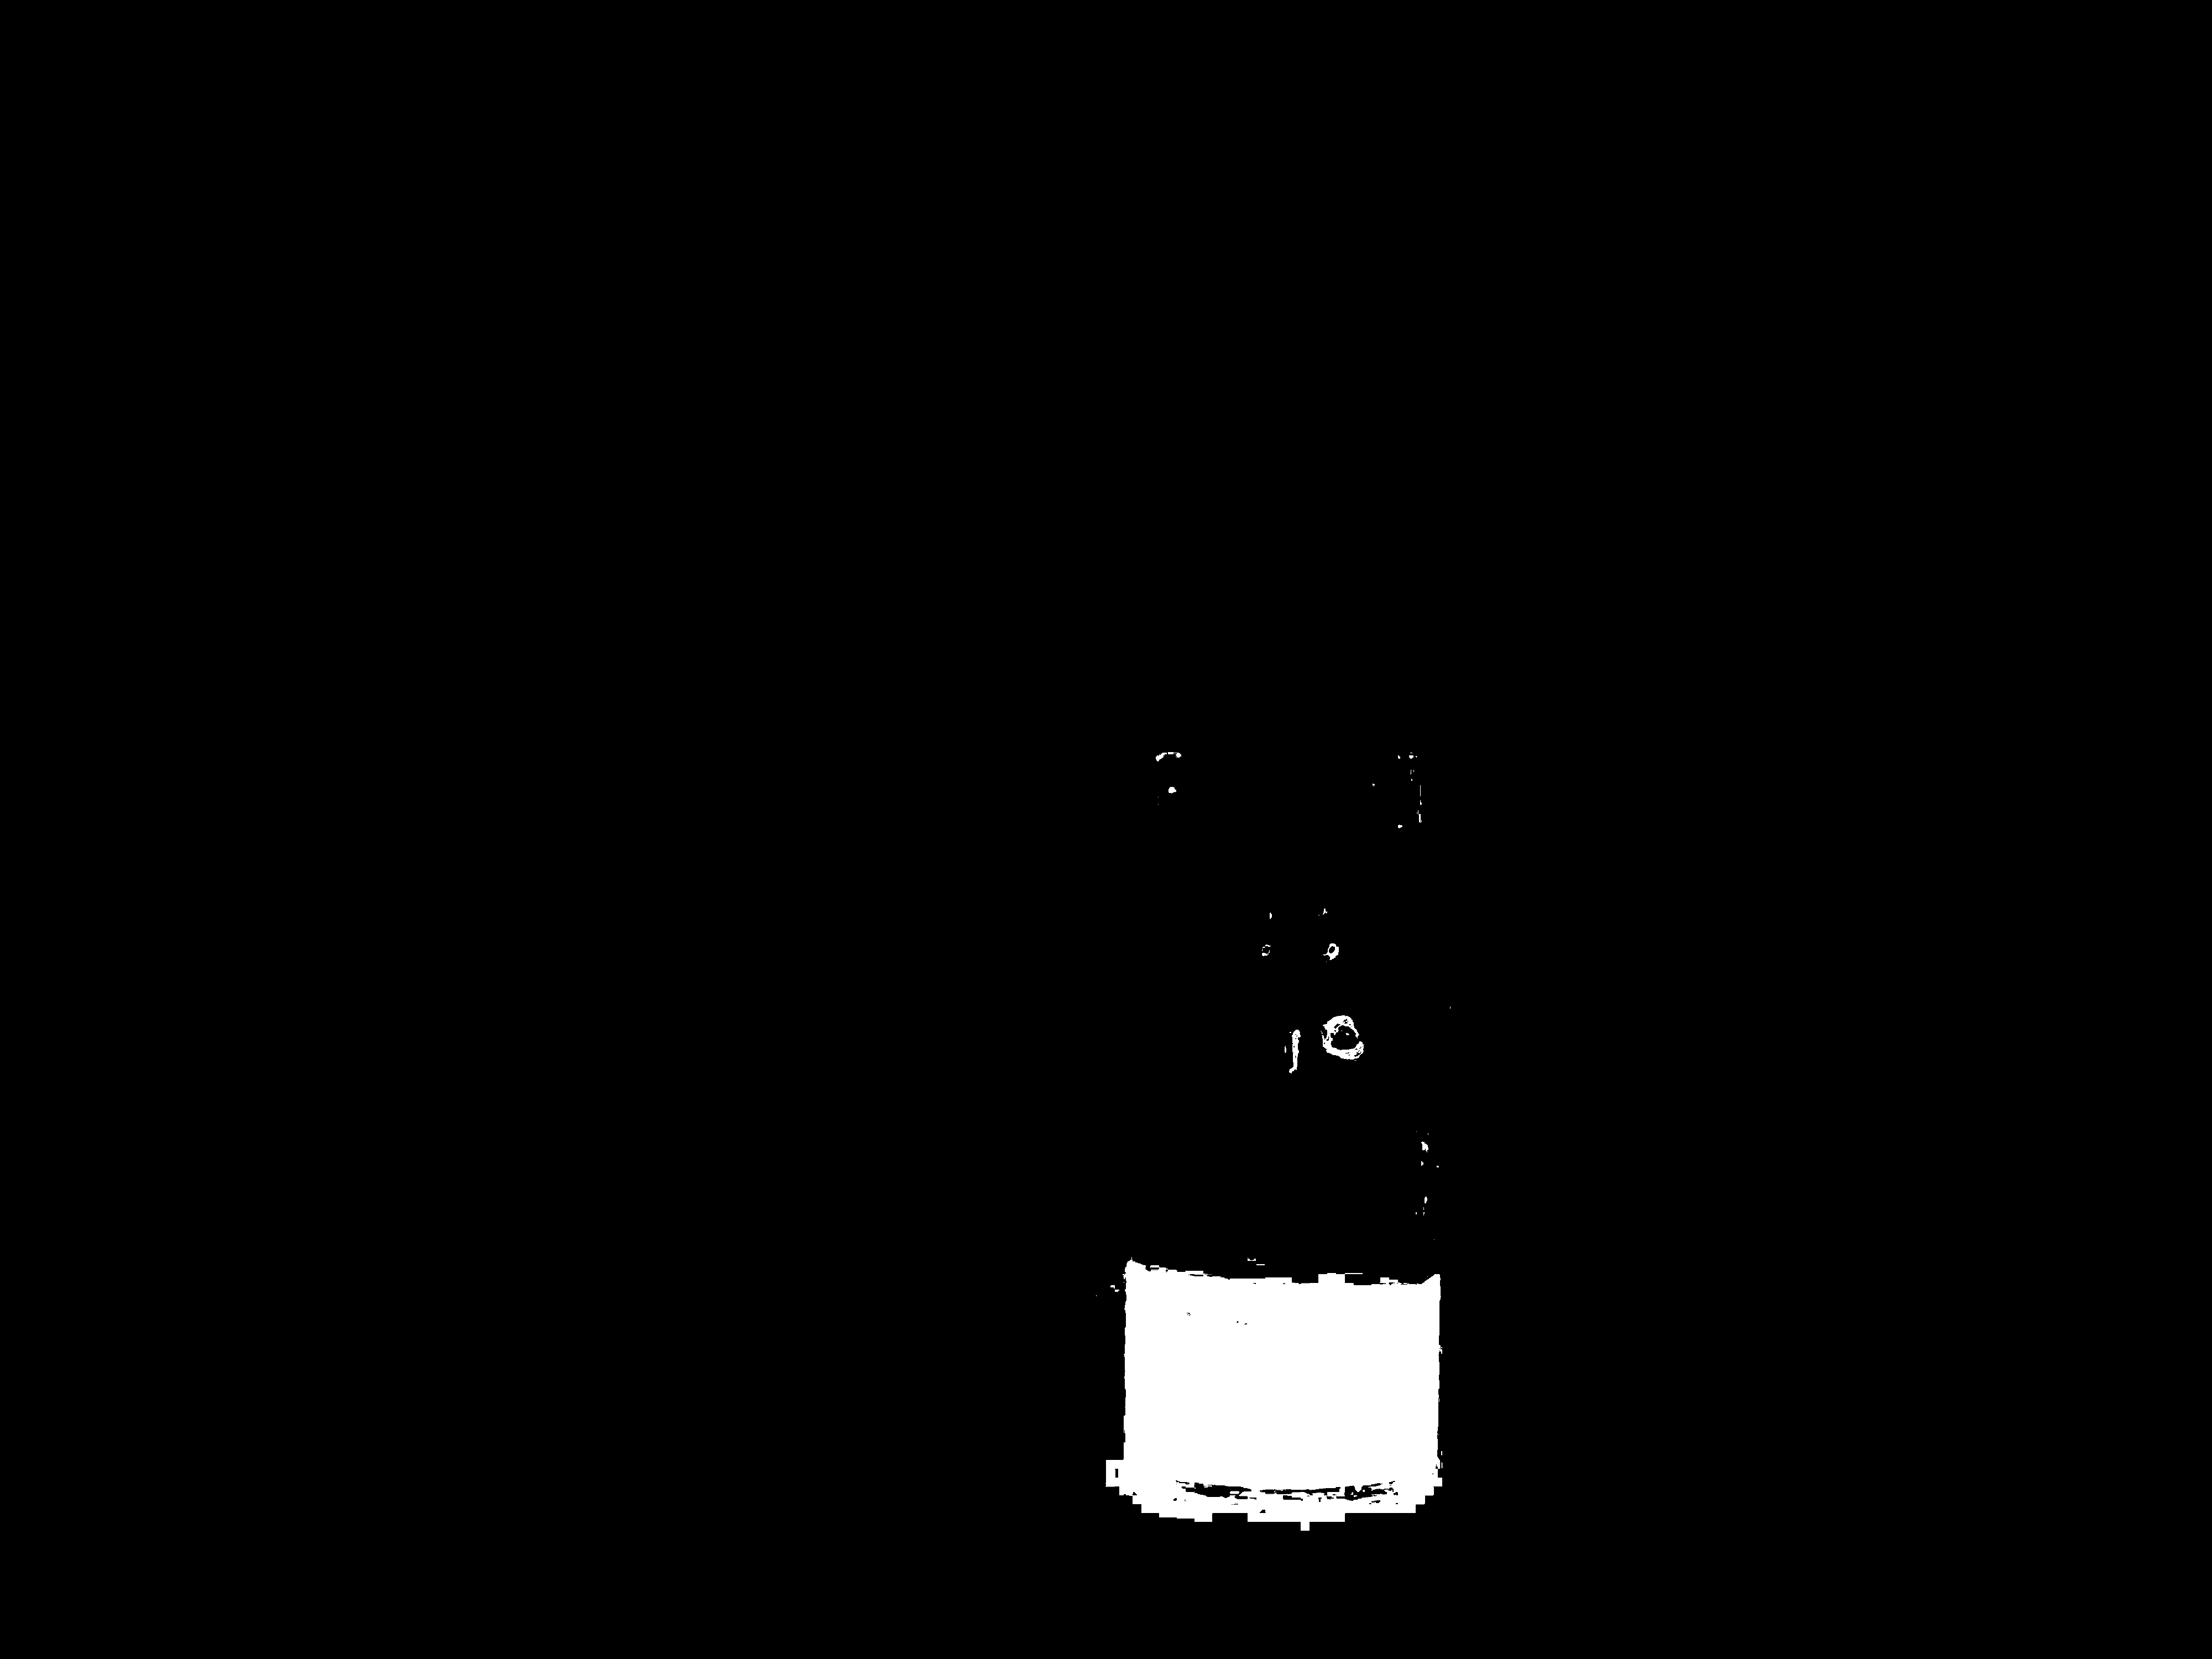

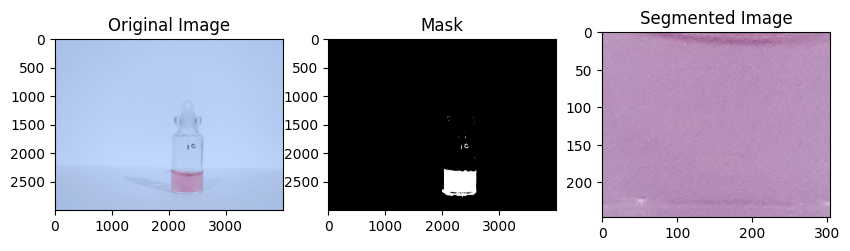

In [123]:
#Modify according to the pigment being processed.
#Valid options are 'curcumin', 'chlrophyll', 'hibiscus', and 'red_cabbage'
pigment = 'hibiscus'


valid_pigments = ['curcumin', 'chlorophyll', 'hibiscus', 'red_cabbage']
if pigment not in valid_pigments:
    raise ValueError(f"Invalid pigment: {pigment}. Choose from {valid_pigments}")

############################    SETTING VALUES FOR TUNING  #####################################################################

#VARIABLES TO TUNE THE THRESHOLDS. ADJUST AS NEEDED.
tune_h_low = 0
tune_s_low = -20 #this works for the four pigments
tune_v_low = 0
tune_h_high = 0
tune_s_high = 0
tune_v_high = 0


######################### LOAD REFERENCE IMAGES FOR THRESHOLD CALCULATION ############################################

# Load images from the lowest and highest concentration that want to be segmented, and from a representative portion of the background
# This images must correspond the region of interest only.

image_low_conc = cv2.imread('/content/drive/MyDrive/Python/Artificial Nanoleaves/Python programs/ImageProcessing/For Github/Hib_dilutions/References_Threshold/lowest.jpg')
image_high_conc = cv2.imread('/content/drive/MyDrive/Python/Artificial Nanoleaves/Python programs/ImageProcessing/For Github/Hib_dilutions/References_Threshold/highest.jpg')
image_background = cv2.imread('/content/drive/MyDrive/Python/Artificial Nanoleaves/Python programs/ImageProcessing/For Github/Hib_dilutions/References_Threshold/background.jpg')

#Load a test image to verify the segmentation
image_to_segment = cv2.imread('/content/drive/MyDrive/Python/Artificial Nanoleaves/Python programs/ImageProcessing/For Github/Hib_dilutions/10.jpg')

##################### OPTIONAL: PLOT HISTOGRAM OF THE REFERENCE IMAGES ############################################
#If fine tuning is needed, fine tune values be easily determined by consulting limits in the histograms
"""
print ('Histogram of lowest concentration:\n')
plotting_histogram_hsv(image_low_conc)
print ('\nHistogram of highest concentration:\n')
plotting_histogram_hsv(image_high_conc)
print ('\nHistogram of background:\n')
plotting_histogram_hsv(image_background)
print ('\nHistogram of test image:\n')
plotting_histogram_hsv(image_to_segment)
"""
######################################################################################################################

# Extracts the minimum and maximum HSV values of each reference image
print ('\nColor range of lowest concentration:')
low_thresh_low_conc, high_thresh_low_conc = calculate_hsv_range(image_low_conc)
print ('Color range of highest concentration:')
low_thresh_high_conc, high_thresh_high_conc = calculate_hsv_range(image_high_conc)
print ('Color range of background:')
low_thresh_background, high_thresh_background = calculate_hsv_range(image_background)


# Calculate the minimum and maximum value color values among low and high concentration images
combined_low_thresh = [
    min(low_thresh_low_conc[0], low_thresh_high_conc[0]),
    min(low_thresh_low_conc[1], low_thresh_high_conc[1]),
    min(low_thresh_low_conc[2], low_thresh_high_conc[2])
]

combined_high_thresh = [
    max(high_thresh_low_conc[0], high_thresh_high_conc[0]),
    max(high_thresh_low_conc[1], high_thresh_high_conc[1]),
    max(high_thresh_low_conc[2], high_thresh_high_conc[2])
]
print(f"\nThe values of the thresholds calculated using only the color ranges are {combined_low_thresh} and {combined_high_thresh}")


#Adjust the threshold to exclude the background. It depends on the relative position
#of the tonality of the background and the tonality of the colored region
if pigment == 'curcumin' or pigment == 'chlorophyll':
    if combined_high_thresh[0] > low_thresh_background[0]:
        combined_high_thresh[0] = low_thresh_background[0]

if pigment == 'hibiscus' or pigment == 'red_cabbage':
    if combined_low_thresh[0] < high_thresh_background[0]:
        combined_low_thresh[0] = high_thresh_background[0]

# Convert to numpy arrays for further processing
low_thresh = np.array(combined_low_thresh, dtype=np.uint8)
high_thresh = np.array(combined_high_thresh, dtype=np.uint8)

low_thresh_background = np.array(low_thresh_background, dtype=np.uint8)
high_thresh_background = np.array(high_thresh_background, dtype=np.uint8)

print(f"\nThe values of the calculated thresholds excluding the background are {low_thresh} and {high_thresh}\n")

# Apply the fine tune values set at the beginning
low_thresh[0] = low_thresh[0] + tune_h_low
low_thresh[1] = low_thresh[1] + tune_s_low
low_thresh[2] = low_thresh[2] + tune_v_low

high_thresh[0] = high_thresh[0] + tune_h_high
high_thresh[1] = high_thresh[1] + tune_s_high
high_thresh[2] = high_thresh[2] + tune_v_high

#Save the thresholds
low_thresh_hsv = low_thresh
high_thresh_hsv = high_thresh
low_thresh_background_hsv = low_thresh_background
high_thresh_background_hsv = high_thresh_background

print(f"\nThe values of the calculated thresholds after fine tuning are {low_thresh} and {high_thresh}\n")

# Segment the image
segmented_image, mask = segment_image_hsv_test(image_to_segment, low_thresh, high_thresh)

# Display the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image_to_segment, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Segmented Image")
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))

plt.show()


# Determination of reference background for the calculation of ΔE


Color coordinates of white background for the calculation of ΔE are extracted from a constant region, so all images that will be processed must have a similar scene

Height: 3000, Width: 4000


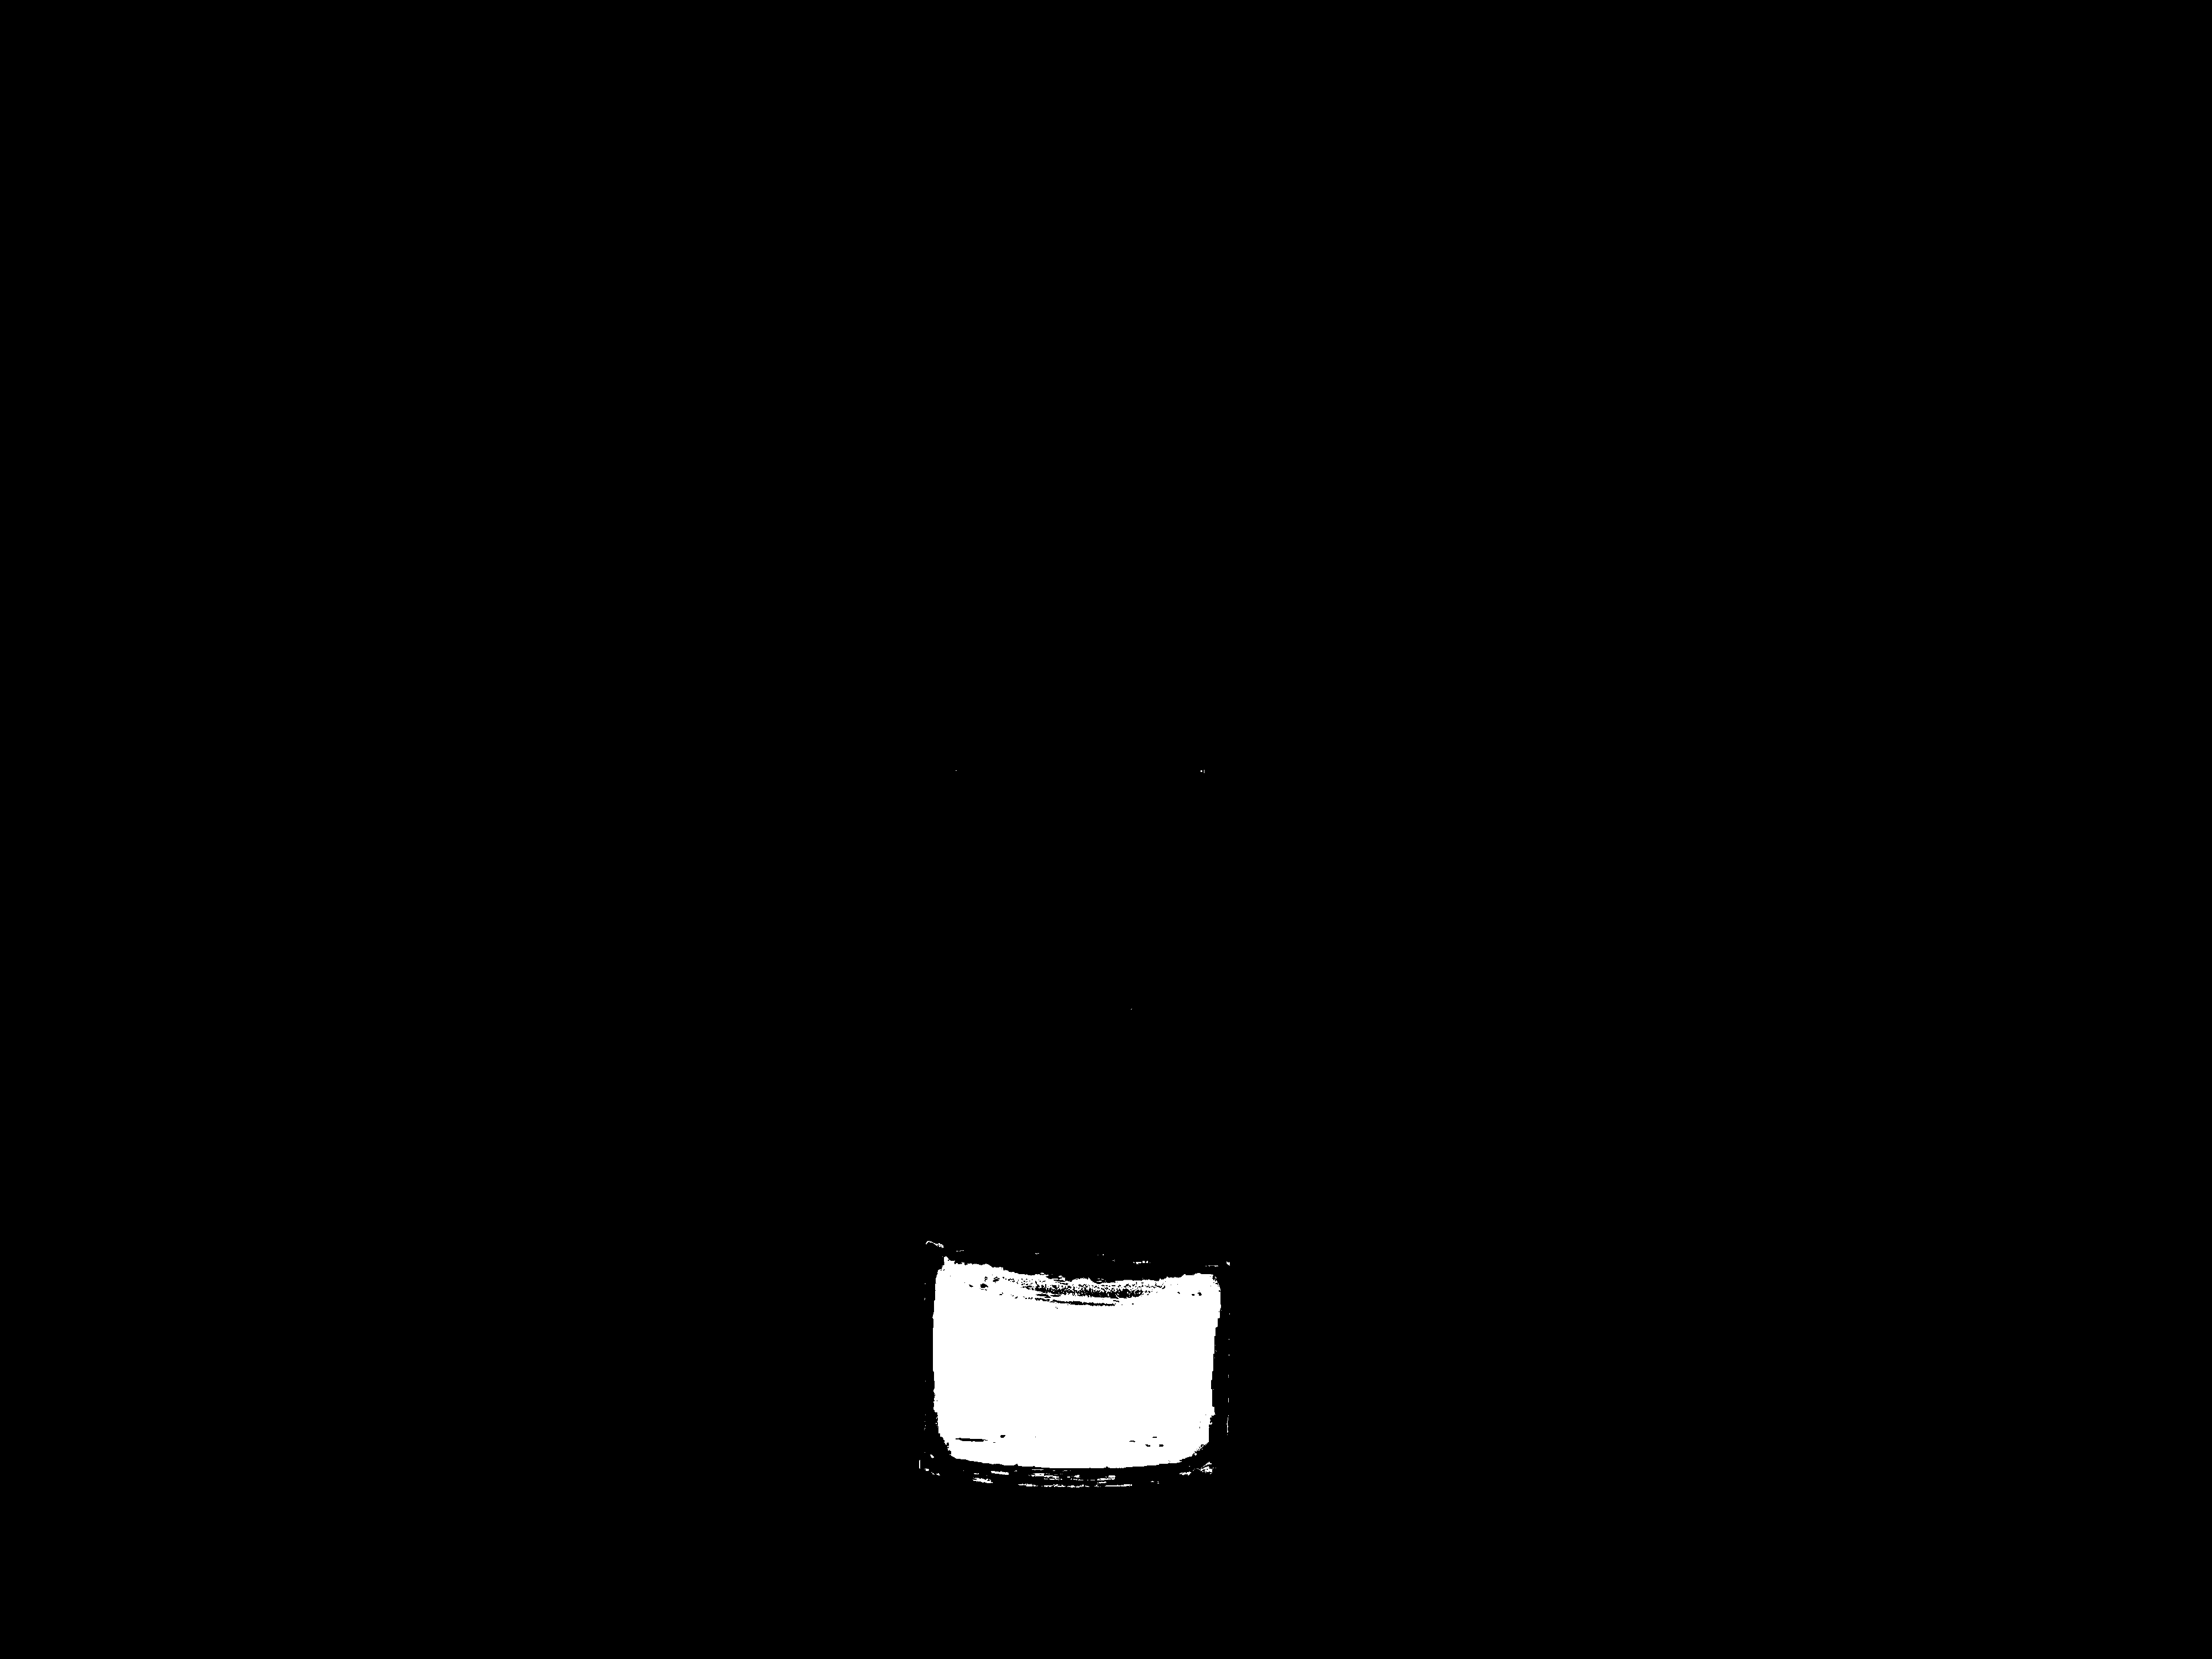


LAB coordinates of colored region are: [ 81.82089293 -22.53964815  32.1822832 ]
LAB coordinates of background region are: [ 78.715313     0.68716667 -20.7601    ]

Color Difference (Euclidean Distance) between the colored solution and the background: 57.89667946093132


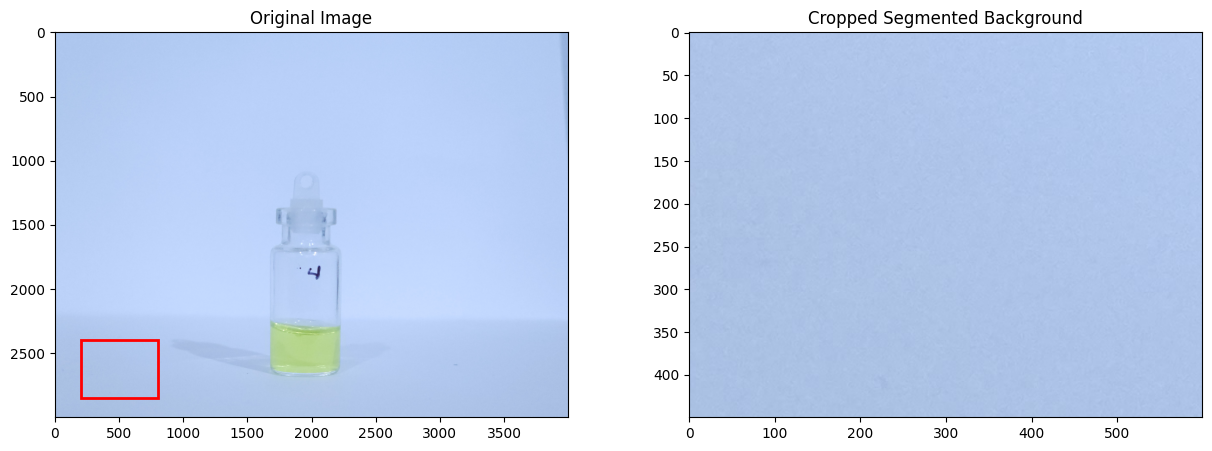

In [72]:
#Determine the position of the reference background from 0 to 1, where the top left corner is (0,0) and bottom right is (1,1)
width_min = 0.05
width_max = 0.2
height_min = 0.8
height_max = 0.95


#Reading test image
image_to_segment = cv2.imread('/content/drive/MyDrive/Python/Artificial Nanoleaves/Python programs/ImageProcessing/For Github/Cur_dilutions/Copia de 20240615_172928.jpg')

# Get the dimensions of the image
height_image, width_image, _ = image_to_segment.shape
print(f"Height: {height_image}, Width: {width_image}")

x_start= int(width_image*width_min)
y_start= int(height_image*height_min)
x_end= int(width_image*width_max)
y_end= int(height_image*height_max)

# Segment the image using calculated thresholds
segmented_image, mask = segment_image_hsv_test(image_to_segment, low_thresh_hsv, high_thresh_hsv)

# Calculate the average LAB coordinates for the segmented image (colored solution)
lab_segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2LAB)
avg_lab_colored_solution = np.mean(lab_segmented_image.reshape(-1, 3), axis=0)

# Crop the segmented background using the set pixel coordinates
cropped_segmented_background = image_to_segment[y_start:y_end, x_start:x_end]

# Convert the cropped background to LAB color space and calculate the average LAB values
cropped_segmented_background_lab = cv2.cvtColor(cropped_segmented_background, cv2.COLOR_BGR2LAB)
avg_lab_background = np.mean(cropped_segmented_background_lab.reshape(-1, 3), axis=0)

std_avg_lab_colored_solution= lab_conversion(avg_lab_colored_solution)
std_avg_lab_background= lab_conversion(avg_lab_background)

print(f"\nLAB coordinates of colored region are: {std_avg_lab_colored_solution}")
print(f"LAB coordinates of background region are: {std_avg_lab_background}\n")

# Calculate color difference
color_difference = calculate_euclidean_distance(std_avg_lab_colored_solution, std_avg_lab_background)
print(f"Color Difference (Euclidean Distance) between the colored solution and the background: {color_difference}")

# Display the original image, mask, and segmented result for the background
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image_to_segment, cv2.COLOR_BGR2RGB))
# Add a Rectangle patch to highlight the cropped region
rect = Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.subplot(1, 2, 2)
plt.title("Cropped Segmented Background")
plt.imshow(cv2.cvtColor(cropped_segmented_background, cv2.COLOR_BGR2RGB))

plt.show()

#Segmentation of image using color segmentation in HSV

* The first image should be the less concentrated, if not, use **path.reverse()**

In [124]:
################ DEFINE READING AND WRITING PATHS #########################################
#Path to the folder where the images of the dilutions are
img_folder = '/content/drive/MyDrive/Python/Artificial Nanoleaves/Python programs/ImageProcessing/For Github/Hib_dilutions'
#Path to the folder where the final segmented images will be stored
write_folder = '/content/drive/MyDrive/Python/Artificial Nanoleaves/Python programs/ImageProcessing/For Github/Hib_dilutions/Segmented_Images_HSV'

# Define the paths for saving the Excel files containing rgb and cielab coordinates
rgb_excel_path = os.path.join(img_folder, 'rgb_values_hsv_segmentation.xlsx')
cielab_excel_path = os.path.join(img_folder, 'cielab_values_hsv_segmentation.xlsx')
hsv_excel_path = os.path.join(img_folder, 'hsv_values_hsv_segmentation.xlsx')

########################### READING THE CONCENTRATION OF DILUTIONS FROM A REFERENCE FILE ##############

reference_data= pd.read_excel('/content/drive/MyDrive/Python/Artificial Nanoleaves/Python programs/ImageProcessing/For Github/Reference_data_concentrations_pigment_dilutions.xlsx', sheet_name='Hib')

#to sort from lower to highest value
reference_data = reference_data.sort_values(by= ['Concentration'])
concentrations= np.array(reference_data['Concentration'])
print(f"\nConcentration (%) of dilutions are: {concentrations}\n")

###########################INITIALIZING VARIABLES##########################################

#Importing the thresholds calculated at the beginning
lower_threshold = low_thresh_hsv
upper_threshold = high_thresh_hsv

hsv_values = []
rgb_values= []
cielab_values = []
cielab_background= []
color_difference_list= []

##########################ITERATIVE SEGMENTATION OF THE IMAGES ##########################################

# Sorting image filenames by the numeric part in increasing order
img_path = sorted([f for f in os.listdir(img_folder) if f.endswith('.jpg')], key=extract_number)

#To match dilutions with concentrations
img_path.reverse()

for img_filename  in img_path:

    write_path = os.path.join(write_folder, img_filename)

    img_path_full = os.path.join(img_folder, img_filename)
    print(img_path_full)
    image = cv2.imread(img_path_full)

    cropped_zone, mask = segment_image_hsv(image, low_thresh_hsv, high_thresh_hsv)
    cv2.imwrite(write_path, cropped_zone)
    print(f'Segmented image have been saved in directory: {write_path}')

    rgb_image = cv2.cvtColor(cropped_zone, cv2.COLOR_BGR2RGB)
    rgb_avg= np.mean(rgb_image.reshape(-1, 3), axis=0)
    rgb_values.append(rgb_avg)

    hsv_image = cv2.cvtColor(cropped_zone, cv2.COLOR_BGR2HSV)
    avg_hsv_colored_solution = np.mean(hsv_image.reshape(-1, 3), axis=0)
    hsv_values.append(avg_hsv_colored_solution)

    cielab_image= cv2.cvtColor(cropped_zone, cv2.COLOR_BGR2LAB)
    avg_lab_colored_solution = np.mean(cielab_image.reshape(-1, 3), axis=0)
    std_avg_lab_colored_solution= lab_conversion(avg_lab_colored_solution)
    cielab_values.append(std_avg_lab_colored_solution)

    avg_lab_background = cropping_background(image,x_start, y_start, x_end, y_end)
    std_avg_lab_background = lab_conversion(avg_lab_background)
    cielab_background.append(std_avg_lab_background)

    print(f"LAB coordinates of colored region are: {std_avg_lab_colored_solution}")
    print(f"LAB coordinates of background region are: {std_avg_lab_background}")

    # Calculate color difference Delta_E
    color_difference = calculate_euclidean_distance(std_avg_lab_colored_solution, std_avg_lab_background)
    color_difference_list.append(color_difference)
    print(f"Color Difference (Euclidean Distance) between the colored solution and the background: {color_difference}")

###########################EXPORTING COLOR COORDINATES in excel files##########################################

rgb_values = np.array(rgb_values)
hsv_values = np.array(hsv_values)
cielab_values = np.array(cielab_values)
cielab_background = np.array(cielab_background)
color_difference_array= np.array(color_difference_list)

print(rgb_values)
print(cielab_values)

#EXPORTING COLORIMETRIC VALUES AS EXCEL FILES
rgb_df = pd.DataFrame(rgb_values, columns=['R', 'G', 'B'])
hsv_df = pd.DataFrame(hsv_values, columns=['H', 'S', 'V'])
cielab_df = pd.DataFrame(cielab_values, columns=['L', 'a', 'b'])
cielab_background_df= pd.DataFrame(cielab_background, columns=['L_background', 'a_background', 'b_background'])
color_difference_df = pd.DataFrame(color_difference_array, columns=['Delta_E'])

rgb_df['No. dilution'] = range(len(rgb_df), 0, -1)
hsv_df['No. dilution'] = range(len(rgb_df), 0, -1)
cielab_df['No. dilution'] = range(len(rgb_df), 0, -1)

rgb_df['Concentration'] = concentrations
hsv_df['Concentration'] = concentrations
cielab_df['Concentration'] = concentrations

rgb_df = rgb_df[['No. dilution', 'Concentration','R', 'G', 'B']]
hsv_df = hsv_df[['No. dilution', 'Concentration', 'H', 'S', 'V']]
cielab_df = cielab_df[['No. dilution', 'Concentration', 'L', 'a', 'b']]

combined_df = pd.concat([cielab_df, cielab_background_df, color_difference_df], axis=1)

# Export the DataFrames to Excel files
rgb_df.to_excel(rgb_excel_path, index=False)
hsv_df.to_excel(hsv_excel_path, index=False)
combined_df.to_excel(cielab_excel_path, index=False)

# Print confirmation messages
print(f"RGB values exported to '{rgb_excel_path}'")
print(f"HSV values exported to '{hsv_excel_path}'")
print(f"CIELAB values exported to '{cielab_excel_path}'")

Output hidden; open in https://colab.research.google.com to view.